In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'


입장 조건
* 롱 포지션:

    - 가격 > 200 SMA: 현재 가격은 200일 단순 이동 평균(SMA)보다 높아야 합니다.
    - MACD > 신호선: MACD 값이 신호선보다 높아 상승 모멘텀을 나타냅니다.
    - RSI > 50: 상대강도지수(RSI)가 50을 초과하여 강세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

* 매도 포지션:

    - 가격 < 200 SMA: 현재 가격이 200일 SMA보다 낮습니다.
    - MACD < 시그널선: MACD 값이 시그널선보다 작아 하락 모멘텀을 나타냅니다.
    - RSI < 50: RSI가 50 미만으로 약세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

종료 조건
* 롱 포지션:

    - 손절매: 진입 가격보다 낮은 특정 비율(예: 0.5% 또는 조정된 가격)로 설정합니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때, 이는 추세 반전 가능성을 나타냅니다.

* 매도 포지션:

    - 손절매: 진입 가격보다 높은 특정 비율로 설정됩니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때.


In [2]:
backtest = pd.read_csv("./data/Grouped_Backtest_Results_by_Indicator.csv")

In [3]:
backtest_long = backtest.query("Position == 'Long'")
backtest_short = backtest.query("Position == 'Short'")

In [4]:
backtest_long.describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00
mean,43.42,57.22,60.89,-4.44,3.25,15.31,-0.51,-0.38,10.18,25.05,75.94,77.81,62523.12,62637.18,-22.76,160.57
std,18.05,14.41,15.00,16.54,12.20,45.38,11.49,13.60,41.83,56.98,54.38,25.96,573.85,641.02,184.46,238.39
min,20.86,30.83,19.55,-61.83,-47.70,-34.93,-30.02,-34.72,-41.97,-34.17,-18.55,1.87,61789.12,61876.00,-382.25,3.57
25%,30.37,46.32,53.77,-11.94,-2.92,-6.92,-7.13,-8.49,-10.85,-10.76,-1.14,73.06,61980.43,62011.52,-102.97,50.98
50%,36.00,59.34,62.04,-4.21,2.55,2.54,0.27,0.23,-0.92,-3.79,103.62,86.39,62424.50,62533.93,-50.19,86.73
75%,62.38,66.72,70.11,0.26,8.48,22.28,6.13,7.84,20.56,100.39,110.97,94.19,62798.10,62956.06,8.47,161.05
max,81.80,87.74,88.73,33.31,30.94,224.12,20.98,28.22,186.36,143.13,133.01,109.30,63763.43,63890.30,696.38,1379.19


# 숏 분석

## 테스트 중 손실
- 탈출 전략이 잘못 적용 되었다는 것을 확인할 수 있음

In [8]:
backtest_short.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
0,Short,63.63,12.63,18.09,12.65,-19.83,-14.82,10.97,-7.25,-4.10,131.78,-2.59,3.97,2024-10-05 13:12:00+00:00,62361.71,2024-10-05 13:30:00+00:00,62201.46,-160.25,147.76,2024-10-05 13:29:00+00:00
2,Short,67.77,34.41,65.83,8.45,4.41,9.50,0.60,7.44,10.72,112.27,-6.19,51.36,2024-10-05 14:46:00+00:00,62232.14,2024-10-05 15:03:00+00:00,62171.67,-60.47,49.40,2024-10-05 14:55:00+00:00
6,Short,66.15,29.39,60.85,4.91,-2.48,9.52,0.07,3.49,6.35,100.81,-43.21,64.75,2024-10-05 17:33:00+00:00,62023.10,2024-10-05 18:05:00+00:00,61943.22,-79.88,28.26,2024-10-05 17:38:00+00:00
16,Short,83.82,27.06,57.36,3.33,3.24,6.79,-6.83,5.91,7.50,119.26,-5.81,50.02,2024-10-06 03:18:00+00:00,62029.50,2024-10-06 03:36:00+00:00,61954.36,-75.14,62.19,2024-10-06 03:27:00+00:00
23,Short,61.66,44.03,56.60,1.71,-9.90,2.06,-1.02,-7.15,2.31,110.77,-4.10,72.61,2024-10-06 09:06:00+00:00,62036.07,2024-10-06 10:21:00+00:00,62021.55,-14.52,41.18,2024-10-06 09:13:00+00:00
24,Short,82.79,43.52,59.42,-2.64,1.78,-2.05,-7.33,3.63,-5.61,127.25,-1.93,89.84,2024-10-06 10:48:00+00:00,62044.71,2024-10-06 11:11:00+00:00,62013.00,-31.71,33.42,2024-10-06 10:50:00+00:00
26,Short,76.72,42.59,41.81,21.64,0.62,4.72,16.65,6.72,9.38,103.68,-14.35,35.67,2024-10-06 11:39:00+00:00,62139.72,2024-10-06 12:02:00+00:00,62080.33,-59.39,39.06,2024-10-06 12:00:00+00:00
34,Short,73.93,38.99,70.27,17.78,6.74,21.20,6.87,13.38,16.35,101.50,-8.16,74.35,2024-10-06 18:25:00+00:00,62751.18,2024-10-06 18:46:00+00:00,62693.61,-57.57,54.94,2024-10-06 18:30:00+00:00
38,Short,59.58,37.22,46.64,-3.98,-11.18,-8.34,-10.43,-7.07,-5.52,103.23,-4.14,11.66,2024-10-06 21:02:00+00:00,62649.67,2024-10-06 21:13:00+00:00,62561.42,-88.25,65.39,2024-10-06 21:11:00+00:00
44,Short,64.47,29.95,66.83,8.20,0.90,17.97,-5.83,8.92,4.83,118.18,-7.03,87.22,2024-10-07 04:02:00+00:00,63606.94,2024-10-07 04:35:00+00:00,63584.84,-22.10,45.12,2024-10-07 04:05:00+00:00


In [10]:
backtest_short.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00
mean,68.54,33.90,48.21,12.41,-2.71,9.15,-0.24,6.77,12.39,109.37,-11.49,36.39,62842.32,62745.52,-96.80,75.36
std,8.60,8.57,13.55,12.57,10.64,13.43,18.12,13.06,15.48,9.40,10.23,28.88,632.70,597.79,67.57,43.75
min,56.43,12.43,18.09,-3.98,-21.70,-14.82,-55.48,-16.35,-5.61,100.81,-43.21,0.02,62023.10,61943.22,-219.80,6.84
25%,62.02,29.39,41.81,3.33,-9.90,2.73,-10.43,-5.79,-3.12,103.23,-17.39,13.39,62361.71,62201.46,-154.97,41.18
50%,65.64,35.40,46.64,8.45,-0.31,7.70,0.07,6.72,10.72,104.75,-7.03,21.89,62649.67,62572.14,-75.14,62.19
75%,76.72,39.89,58.06,21.64,3.24,17.97,15.22,15.64,19.23,112.27,-4.10,57.12,63383.60,63228.63,-32.15,105.86
max,83.82,46.14,70.27,36.43,21.07,37.67,28.53,41.32,46.39,131.78,-1.40,89.84,63918.95,63713.11,-14.52,154.37


## 테스트 중 이익

In [5]:
backtest_short.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
5,Short,32.03,62.57,34.37,-11.69,-4.72,-32.56,-4.40,-14.43,-32.29,-0.77,111.74,10.83,2024-10-05 16:37:00+00:00,62071.56,2024-10-05 17:22:00+00:00,62018.04,53.52,170.78,2024-10-05 17:09:00+00:00
7,Short,36.44,61.93,56.41,-6.24,2.05,-7.28,1.54,-3.23,-7.76,-6.36,100.81,77.04,2024-10-05 18:06:00+00:00,61963.55,2024-10-05 19:26:00+00:00,61904.15,59.40,155.22,2024-10-05 19:20:00+00:00
8,Short,24.52,56.08,41.36,-11.24,-5.86,-9.37,-5.56,-8.54,-9.21,-13.29,105.59,6.50,2024-10-05 19:46:00+00:00,61790.23,2024-10-05 21:06:00+00:00,61769.14,21.09,88.09,2024-10-05 21:05:00+00:00
12,Short,34.25,62.00,19.71,-0.06,-12.50,-21.97,10.92,-18.42,-7.05,-11.78,113.35,6.90,2024-10-06 00:04:00+00:00,62002.59,2024-10-06 00:25:00+00:00,61999.02,3.57,69.79,2024-10-06 00:09:00+00:00
37,Short,35.71,71.87,16.52,4.69,-1.05,-48.71,20.46,-17.12,-36.56,-17.75,102.35,-8.76,2024-10-06 19:33:00+00:00,62754.00,2024-10-06 20:12:00+00:00,62748.71,5.29,173.18,2024-10-06 19:56:00+00:00
43,Short,31.47,59.12,21.62,-17.14,1.98,-71.87,-0.36,-9.33,-44.95,-18.19,101.94,-5.95,2024-10-07 02:32:00+00:00,63739.81,2024-10-07 04:01:00+00:00,63568.09,171.72,397.27,2024-10-07 03:37:00+00:00
51,Short,36.71,72.30,4.74,-26.45,20.62,-69.89,-17.25,10.67,-50.97,-2.92,149.88,0.17,2024-10-07 09:03:00+00:00,63476.74,2024-10-07 11:57:00+00:00,63045.56,431.18,821.73,2024-10-07 11:08:00+00:00
61,Short,29.82,71.18,6.42,-14.42,-16.15,-160.77,8.91,-69.43,-119.25,-22.05,105.32,3.03,2024-10-07 18:08:00+00:00,63558.76,2024-10-07 19:06:00+00:00,63199.95,358.81,828.98,2024-10-07 18:51:00+00:00
66,Short,33.89,79.61,16.00,-28.68,45.88,-193.71,-19.86,27.85,-121.68,-8.31,106.17,-14.08,2024-10-07 22:33:00+00:00,63128.87,2024-10-08 00:33:00+00:00,62577.23,551.64,1013.72,2024-10-07 23:00:00+00:00
70,Short,25.72,70.81,6.66,-2.26,-19.29,-40.63,15.45,-34.17,-23.12,-1.03,103.39,3.41,2024-10-08 02:14:00+00:00,62570.70,2024-10-08 02:37:00+00:00,62562.66,8.04,157.92,2024-10-08 02:23:00+00:00


In [11]:
backtest_short.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00
mean,31.96,66.29,22.73,-9.55,-0.10,-64.05,2.66,-15.23,-44.89,-11.31,109.37,7.20,62703.68,62526.23,177.45,397.39
std,4.07,7.19,16.04,11.92,18.79,60.24,13.78,25.14,40.33,8.02,14.02,24.30,698.36,581.02,197.94,342.97
min,24.52,56.08,4.74,-28.68,-19.29,-193.71,-19.86,-69.43,-121.68,-22.05,100.81,-14.08,61790.23,61769.14,3.57,69.79
25%,30.40,61.81,11.33,-15.78,-12.31,-70.88,-4.98,-24.90,-47.96,-17.97,102.43,-2.94,62037.07,62008.53,14.56,156.57
50%,32.03,62.57,19.71,-11.24,-4.72,-47.81,1.54,-14.43,-36.56,-11.78,105.32,3.03,62683.69,62562.66,59.40,173.18
75%,34.98,71.53,30.31,-1.16,2.01,-27.26,13.19,-5.89,-16.17,-4.64,108.96,6.70,63302.81,62897.13,323.26,658.19
max,36.71,79.61,56.41,8.44,45.88,-7.28,20.46,27.85,-7.05,-0.77,149.88,77.04,63739.81,63568.09,551.64,1013.72


# 롱

## 테스트 중 손실

In [9]:
backtest_long.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
1,Long,33.00,55.82,62.04,-20.52,3.98,3.09,-19.68,-1.37,-5.66,-2.60,104.71,82.41,2024-10-05 13:41:00+00:00,62181.55,2024-10-05 14:45:00+00:00,62214.20,-32.65,24.26,2024-10-05 14:22:00+00:00
3,Long,41.27,60.18,67.68,-0.05,2.55,0.68,3.68,-0.17,-5.26,-5.33,103.59,95.26,2024-10-05 15:08:00+00:00,62169.32,2024-10-05 15:51:00+00:00,62190.02,-20.70,19.81,2024-10-05 15:28:00+00:00
4,Long,31.12,60.23,56.89,-5.26,1.53,-3.43,-1.06,-8.49,-10.99,-4.16,104.85,88.28,2024-10-05 16:06:00+00:00,62134.71,2024-10-05 16:25:00+00:00,62184.90,-50.19,29.10,2024-10-05 16:24:00+00:00
10,Long,36.12,81.31,62.06,3.79,12.89,2.54,13.43,2.08,-2.33,-10.71,115.17,86.86,2024-10-05 21:51:00+00:00,61863.26,2024-10-05 22:04:00+00:00,61986.02,-122.76,86.73,2024-10-05 22:02:00+00:00
13,Long,33.85,59.86,55.51,-15.51,-2.92,-5.74,-12.25,-9.00,-10.52,-18.37,107.29,94.19,2024-10-06 00:35:00+00:00,61906.31,2024-10-06 01:01:00+00:00,61944.14,-37.83,31.74,2024-10-06 01:00:00+00:00
15,Long,37.99,57.63,60.75,-6.03,-3.08,-7.84,-1.70,-9.37,-13.05,-2.33,104.42,82.49,2024-10-06 02:33:00+00:00,61980.43,2024-10-06 03:17:00+00:00,61997.59,-17.16,23.47,2024-10-06 02:49:00+00:00
17,Long,26.32,57.56,39.07,0.26,-0.68,-8.50,4.78,-5.46,-3.28,-1.42,103.47,29.10,2024-10-06 03:37:00+00:00,61950.00,2024-10-06 04:18:00+00:00,61958.76,-8.76,3.57,2024-10-06 03:42:00+00:00
18,Long,25.94,82.71,80.57,-11.94,2.44,0.08,-5.85,-3.31,-4.74,-17.73,101.35,88.13,2024-10-06 04:39:00+00:00,61851.73,2024-10-06 05:01:00+00:00,61909.37,-57.64,44.14,2024-10-06 05:00:00+00:00
19,Long,38.60,66.76,61.29,-4.21,3.68,-1.59,-0.59,-3.50,-5.29,-3.79,112.32,81.11,2024-10-06 05:09:00+00:00,61845.75,2024-10-06 05:21:00+00:00,61932.77,-87.02,51.46,2024-10-06 05:20:00+00:00
21,Long,30.08,57.53,85.01,-1.82,-2.53,8.56,2.18,-6.87,6.30,-34.17,108.93,95.81,2024-10-06 06:47:00+00:00,61949.53,2024-10-06 08:15:00+00:00,61978.54,-29.01,64.10,2024-10-06 07:20:00+00:00


## 테스트 중 이익

In [6]:
backtest_long.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
9,Long,67.77,38.19,78.98,-1.46,7.66,22.28,-7.13,15.84,22.89,118.56,-4.68,95.40,2024-10-05 21:07:00+00:00,61789.12,2024-10-05 21:50:00+00:00,61876.00,86.88,160.88,2024-10-05 21:44:00+00:00
11,Long,81.80,36.21,77.83,17.04,5.34,20.96,5.07,13.67,17.19,100.39,-13.66,86.39,2024-10-05 22:05:00+00:00,61974.33,2024-10-06 00:03:00+00:00,62011.52,37.19,137.94,2024-10-05 23:57:00+00:00
14,Long,62.38,36.84,63.46,0.03,-2.89,42.92,-7.20,-0.62,33.42,108.05,-2.67,85.50,2024-10-06 01:02:00+00:00,61953.13,2024-10-06 02:32:00+00:00,61986.66,33.53,202.28,2024-10-06 01:28:00+00:00
20,Long,73.85,35.13,67.06,10.54,1.32,11.34,-0.69,5.53,8.71,121.35,-0.39,109.30,2024-10-06 05:22:00+00:00,61967.41,2024-10-06 06:40:00+00:00,61980.80,13.39,54.53,2024-10-06 06:21:00+00:00
22,Long,64.96,46.59,57.88,0.11,-0.80,24.19,-5.47,1.98,20.60,102.00,-4.83,70.37,2024-10-06 08:16:00+00:00,61979.48,2024-10-06 08:55:00+00:00,61987.95,8.47,99.87,2024-10-06 08:32:00+00:00
27,Long,59.08,35.88,86.40,7.28,4.18,48.52,4.13,14.71,32.63,105.80,-1.14,103.84,2024-10-06 12:07:00+00:00,62163.81,2024-10-06 13:29:00+00:00,62248.42,84.61,203.58,2024-10-06 13:04:00+00:00
29,Long,74.91,46.32,70.52,23.84,-6.25,84.11,16.84,10.04,75.96,100.29,-3.37,85.02,2024-10-06 14:26:00+00:00,62384.88,2024-10-06 15:20:00+00:00,62518.63,133.75,395.08,2024-10-06 14:58:00+00:00
31,Long,77.08,31.82,88.73,-2.25,-9.60,76.76,-15.84,10.75,63.30,103.14,-2.45,91.22,2024-10-06 15:40:00+00:00,62613.78,2024-10-06 16:26:00+00:00,62668.11,54.33,318.03,2024-10-06 16:08:00+00:00
36,Long,74.69,39.58,64.09,13.45,14.72,29.89,4.79,24.40,27.87,118.29,-3.05,94.00,2024-10-06 19:03:00+00:00,62798.10,2024-10-06 19:32:00+00:00,62799.89,1.79,185.68,2024-10-06 19:30:00+00:00
40,Long,70.77,38.33,65.46,27.62,-0.56,41.77,20.98,7.84,26.98,143.13,-14.20,96.88,2024-10-06 23:00:00+00:00,62706.34,2024-10-07 00:10:00+00:00,62751.18,44.84,217.37,2024-10-06 23:44:00+00:00


# 시각화

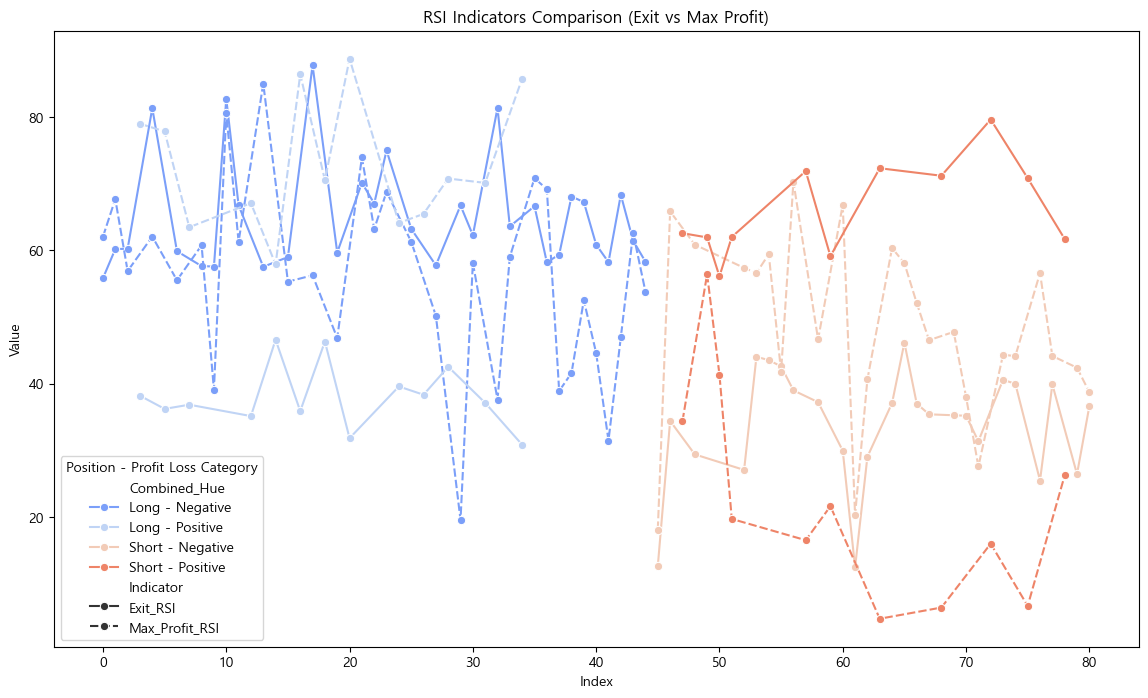

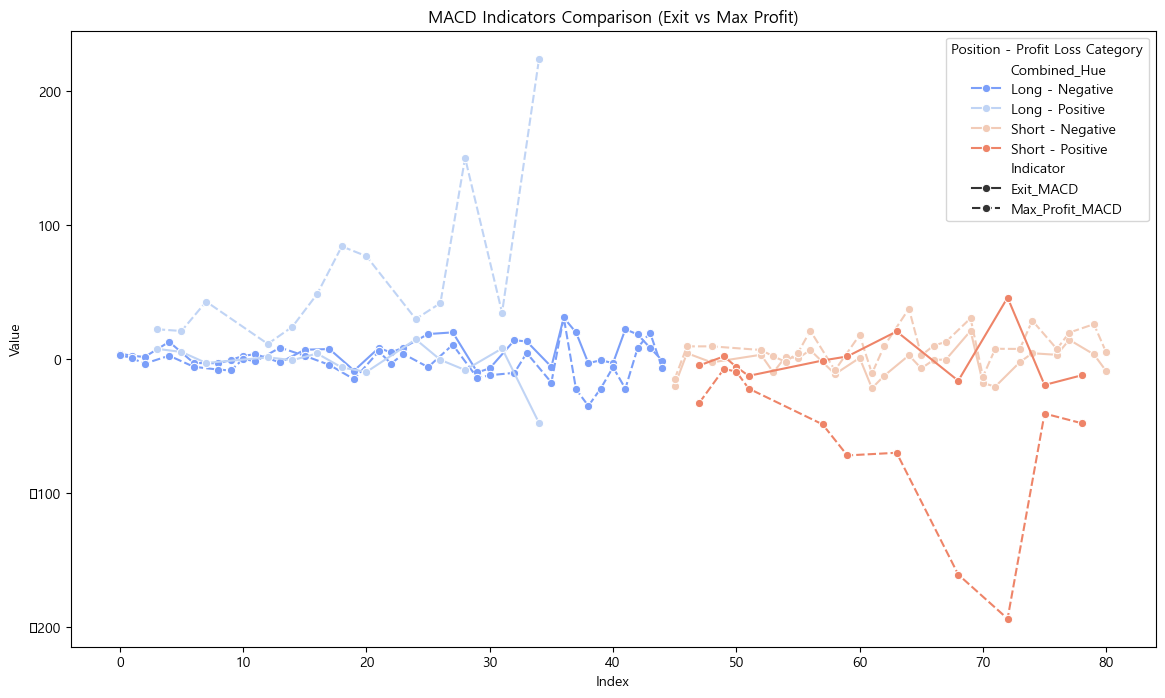

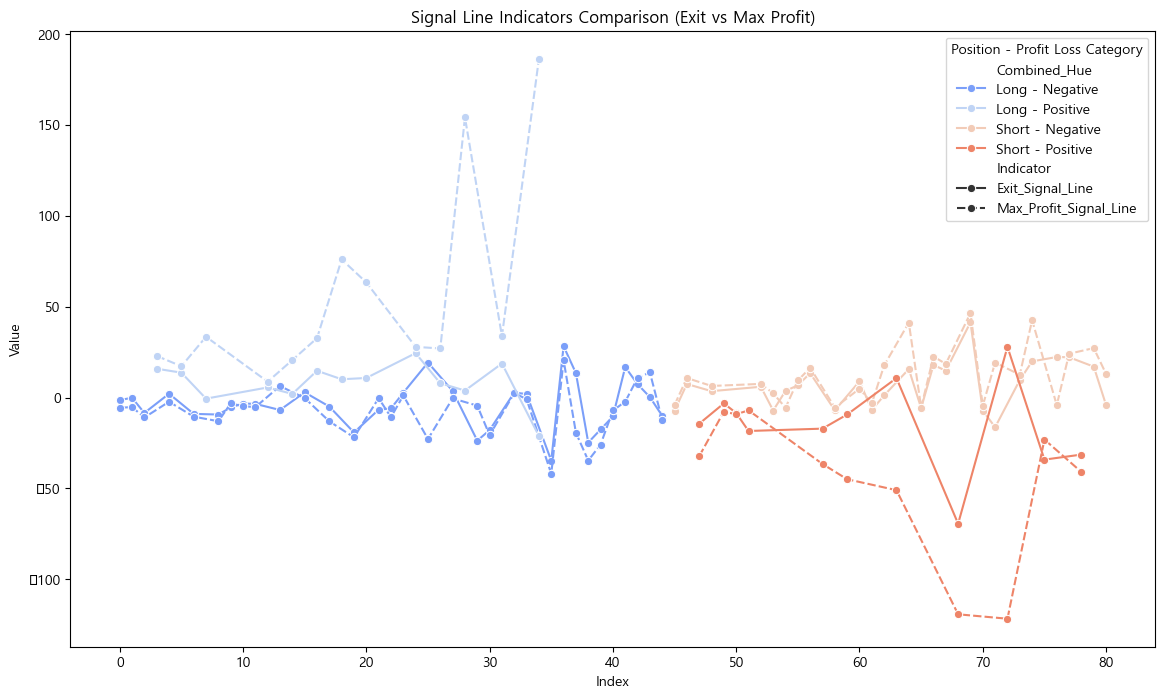

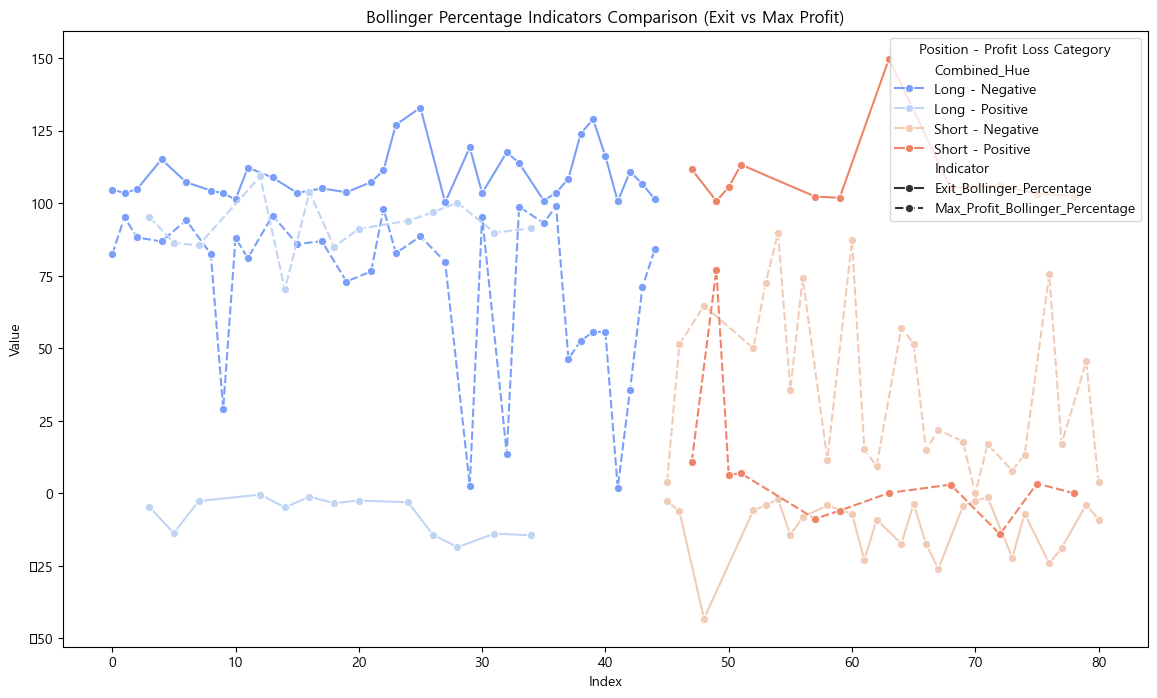

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have combined_data from backtest_long and backtest_short data
combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Position and Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")
plot_data["Combined_Hue"] = plot_data["Position"] + " - " + plot_data["Profit_Loss_Category"]

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot RSI indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_RSI", "Max_Profit_RSI"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("RSI Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot MACD indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_MACD", "Max_Profit_MACD"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("MACD Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Signal Line indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Signal_Line", "Max_Profit_Signal_Line"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Signal Line Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Bollinger Percentage indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Bollinger Percentage Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()


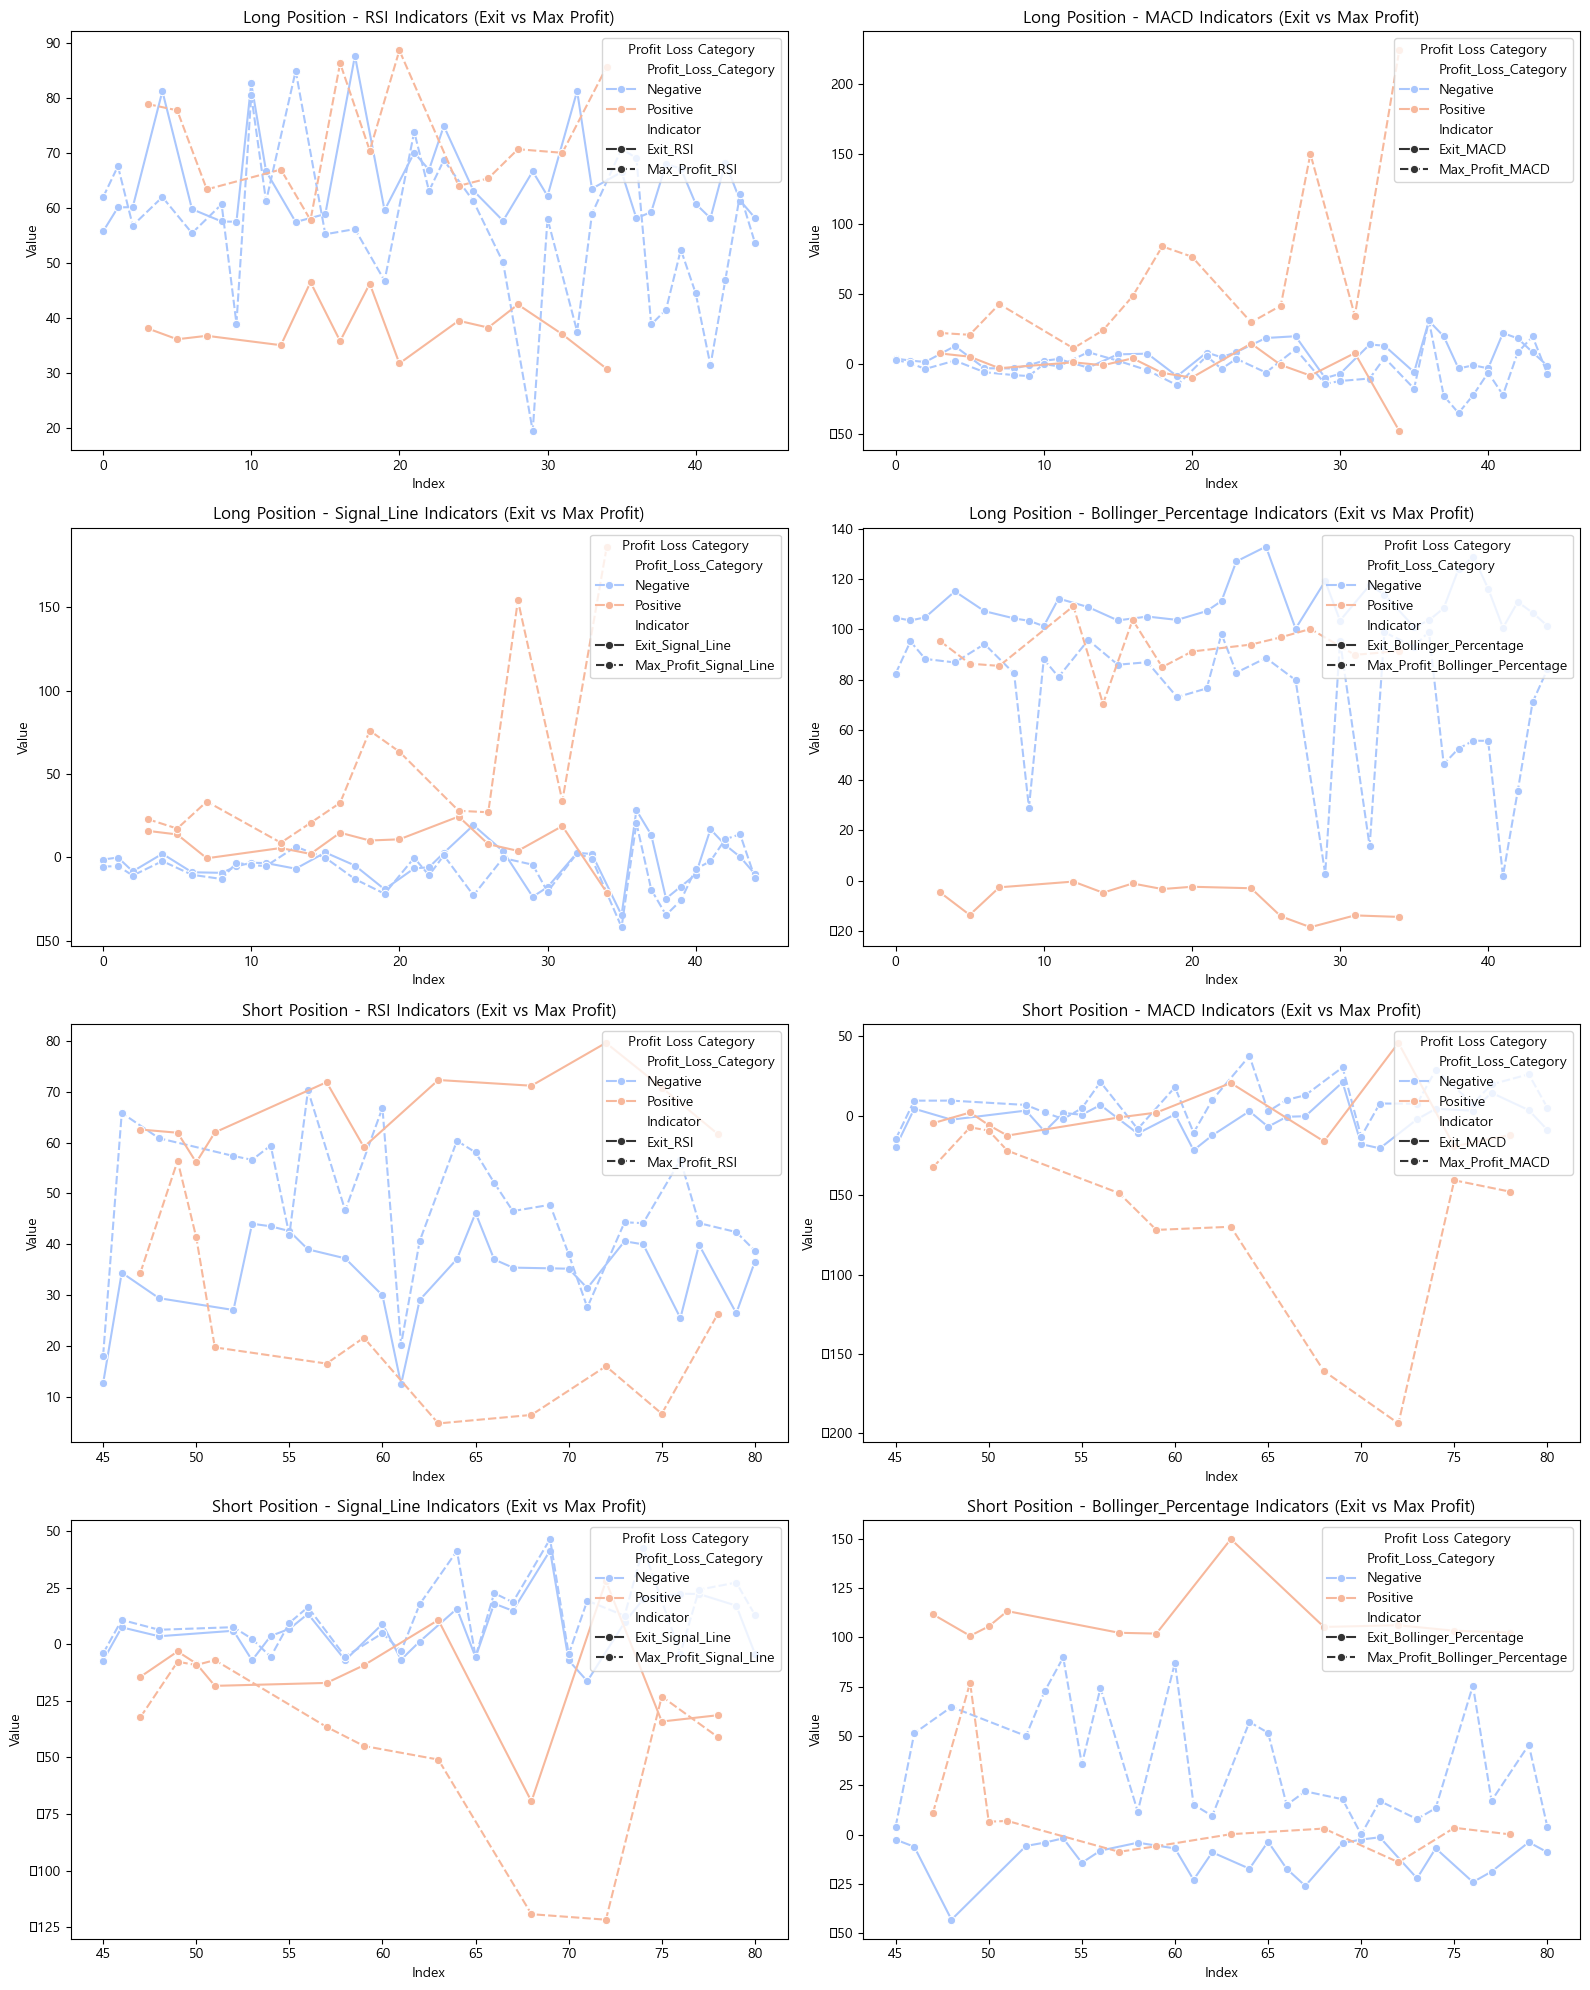

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 8 graphs
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs = {
    "RSI": ["Exit_RSI", "Max_Profit_RSI"],
    "MACD": ["Exit_MACD", "Max_Profit_MACD"],
    "Signal_Line": ["Exit_Signal_Line", "Max_Profit_Signal_Line"],
    "Bollinger_Percentage": ["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"]
}

# Loop through positions and indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific indicator pair
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", style="Indicator", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Indicators (Exit vs Max Profit)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()


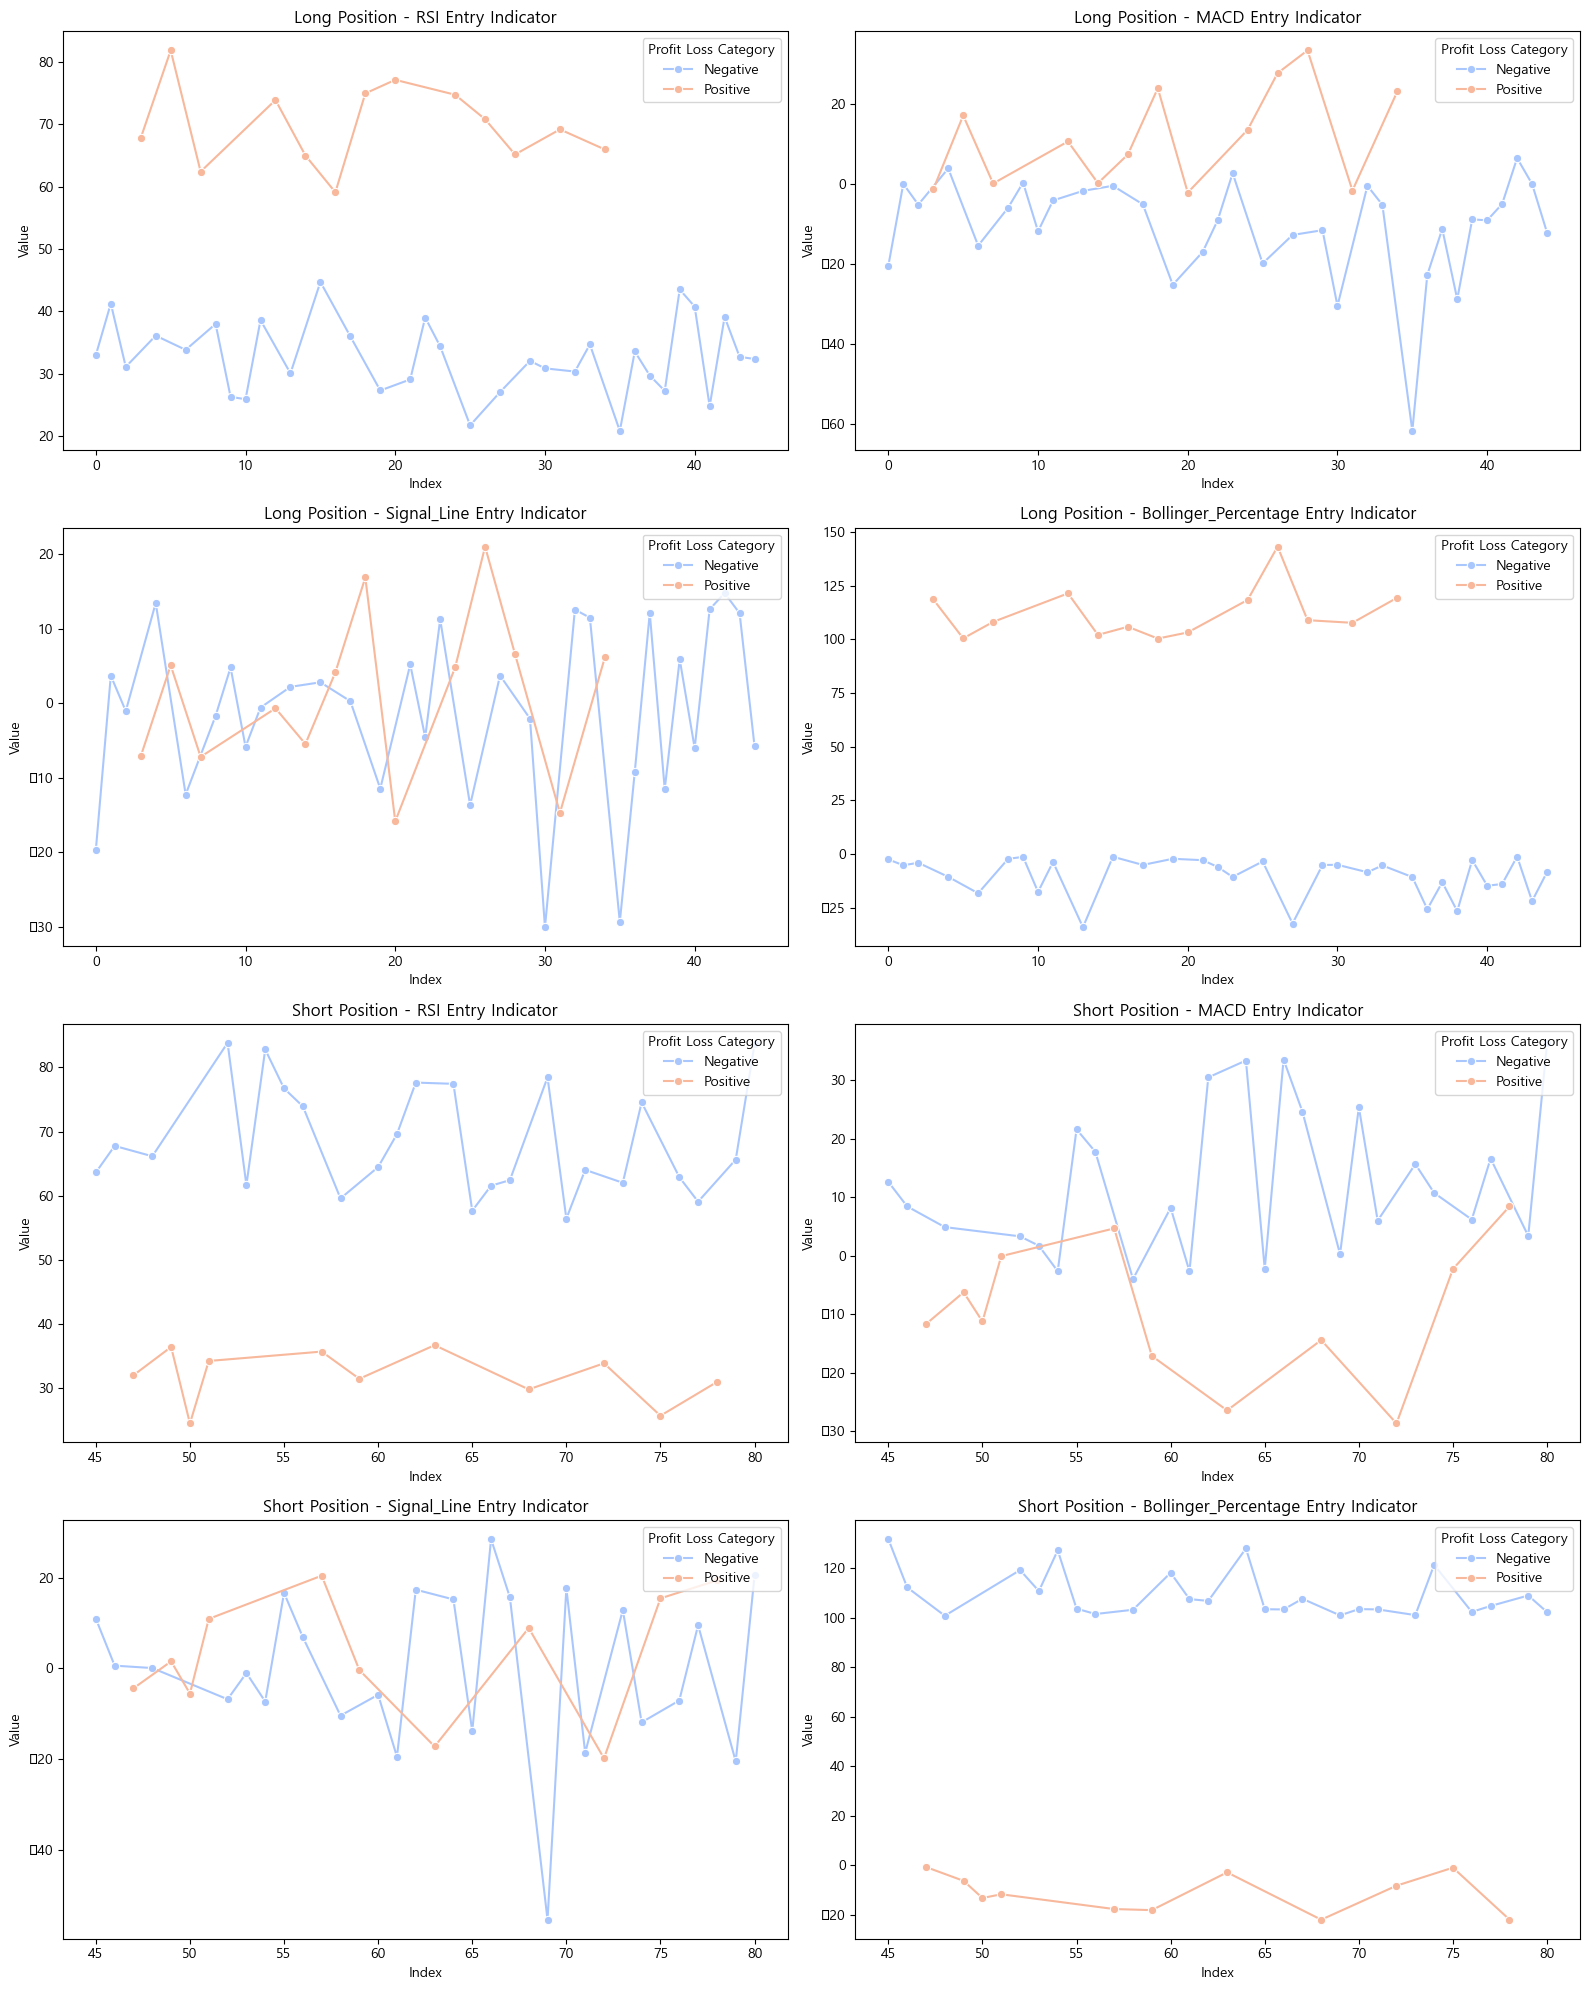

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups for entry, exit, and max profit
entry_indicators = ["Entry_RSI", "Entry_MACD", "Entry_Signal_Line", "Entry_Bollinger_Percentage"]

# Melt the data to include entry indicators
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=entry_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 4 graphs (Long and Short positions separated for each indicator)
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs_entry = {
    "RSI": ["Entry_RSI"],
    "MACD": ["Entry_MACD"],
    "Signal_Line": ["Entry_Signal_Line"],
    "Bollinger_Percentage": ["Entry_Bollinger_Percentage"]
}

# Loop through positions and entry indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific entry indicator
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs_entry[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Entry Indicator")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()
